In [1]:
import os 
import glob
import random
from itertools import chain
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
source = '../input/fruits/fruits-360_dataset/fruits-360/Training'
dirnames = os.listdir(source)
dirnames = dirnames[:10]
dirnames

['Quince',
 'Grapefruit White',
 'Granadilla',
 'Orange',
 'Apple Red 3',
 'Grape White 2',
 'Corn Husk',
 'Tamarillo',
 'Banana Red',
 'Nectarine Flat']

In [7]:
dataset = np.array('start')
for name in dirnames:
    dataset = np.append(dataset, glob.glob(f'{source}/{name}/*.jpg'))
random.shuffle(dataset)

In [8]:
# Removing the first element of dataset array
dataset = np.delete(dataset, 0)

In [9]:
dataset[:5]

array(['../input/fruits/fruits-360_dataset/fruits-360/Training/Banana Red/r_209_100.jpg',
       '../input/fruits/fruits-360_dataset/fruits-360/Training/Apple Red 3/r_218_100.jpg',
       '../input/fruits/fruits-360_dataset/fruits-360/Training/Corn Husk/67_100.jpg',
       '../input/fruits/fruits-360_dataset/fruits-360/Training/Tamarillo/r_127_100.jpg',
       '../input/fruits/fruits-360_dataset/fruits-360/Training/Tamarillo/r_79_100.jpg'],
      dtype='<U85')

In [10]:
dataset = dataset[2000:3000]

In [11]:
name = dataset[0].split('/')[-2]
name

'Granadilla'

In [12]:
labels = np.array('start')
for item in dataset:
    name = str(item).split('/')[-2]
    labels = np.append(labels, name)
labels = np.delete(labels, 0)
len(labels)

1000

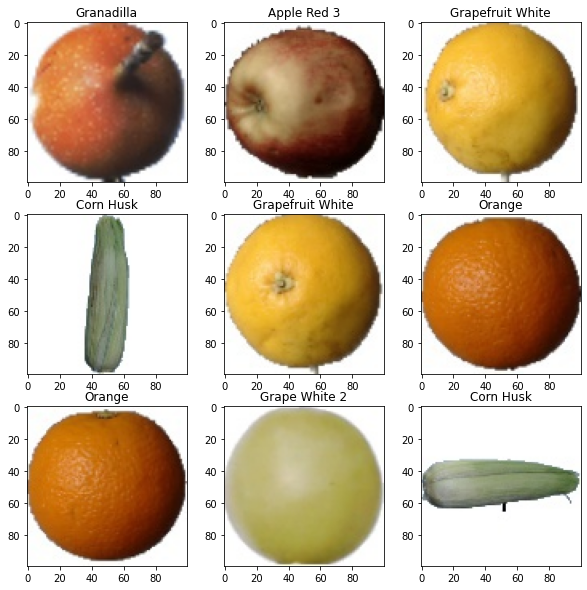

In [13]:
fig, ax = plt.subplots(3, 3, figsize=(10,10))
index = 0
for i in range(3):
    for j in range(3):
        img = cv2.imread(dataset[index])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i][j].imshow(img)
        ax[i][j].set_title(labels[index])
        index += 1

In [14]:
x_test = dataset[:100]
y_test = labels[:100]
dataset = dataset[100:]
labels = labels[100:]

# OneHotEncoder

In [15]:
labels = labels.reshape(-1,1)
enc = OneHotEncoder()
encoded_labels = enc.fit(labels)
enc_labels = encoded_labels.transform(labels).toarray()

In [16]:
labels[:8]

array([['Banana Red'],
       ['Tamarillo'],
       ['Grape White 2'],
       ['Grapefruit White'],
       ['Apple Red 3'],
       ['Quince'],
       ['Nectarine Flat'],
       ['Apple Red 3']], dtype='<U16')

### Testing OneHotEncoding results:

In [17]:
np.testing.assert_array_equal(enc_labels[4], enc_labels[7])

In [18]:
x_train, x_val, y_train, y_val = train_test_split(dataset, enc_labels, test_size=0.2)

In [19]:
WIDTH = 30
HEIGHT = 30
BATCH_SIZE = 32

In [20]:
class  DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, filenames, labels, batch_size = BATCH_SIZE, shuffle = True):
        self.filenames = filenames
        self.labels = labels
        self.data = list(zip(self.filenames, self.labels))
        self.batch_size = BATCH_SIZE
        self.shuffle = shuffle
    
    def __len__(self):
        return (len(self.filenames) // self.batch_size)
    
    def __getitem__(self, idx):
        batch = self.data[idx * self.batch_size : (idx + 1) * self.batch_size]
        X, Y = self.__data_generation(batch)

        return X, Y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, batch):
        x = np.array('start')
        y = np.array(12)
        
        for filename, labels in batch:
            image = cv2.imread(filename) / 255
            image = cv2.resize(image, (WIDTH, HEIGHT))
            x = np.append(x, image)
            y = np.append(y, labels)
        
        x = np.delete(x, 0)
        x = np.reshape(x, (32,2700))
        y = np.asarray(y, float)
        y = np.delete(y, 0)
        y = np.reshape(y, (32,10))
        
        return  x, y
      

In [21]:
train_generator = DataGenerator(x_train, y_train, BATCH_SIZE)
val_generator = DataGenerator(x_val, y_val, BATCH_SIZE)

In [24]:
model = tf.keras.models.Sequential([
    Flatten(input_shape=(WIDTH,HEIGHT,3)),
    Dense(750, activation='relu'),
    Dropout(0.1),
    Dense(250, activation='relu'),
    Dropout(0.1),
    Dense(70, activation='relu'),
    Dropout(0.1),
    Dense(10, activation='softmax')
])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2700)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 750)               2025750   
_________________________________________________________________
dropout_3 (Dropout)          (None, 750)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               187750    
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 70)                17570     
_________________________________________________________________
dropout_5 (Dropout)          (None, 70)               

In [26]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

In [28]:
history = model.fit(train_generator,
                   validation_data = val_generator,
                   epochs = 4)

Epoch 1/4


2022-05-10 07:24:57.288303: W tensorflow/core/framework/op_kernel.cc:1669] OP_REQUIRES failed at cast_op.cc:121 : Unimplemented: Cast string to float is not supported


UnimplementedError:  Cast string to float is not supported
	 [[node sequential_1/Cast (defined at tmp/ipykernel_33/573651436.py:3) ]] [Op:__inference_train_function_956]

Function call stack:
train_function
